In [1]:
# load libraries
import pandas as pd
import os
import numpy as np
import datetime
from torch.utils.data import Dataset, DataLoader
from torch import save

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change me, have to point to the Meteotrentino drive folder
wk =  "/content/drive/My Drive/10. Meteotrentino/"

# path to the datasets
dataset_path = wk+"DatasetPytorch/"

# specify sensor type
sensor_type = "pioggia"

file_name_test = "test_join_tsf.pt"
file_name_train = "train_join_tsf.pt"

# extrapolate the paths
file_test_to_read_path = os.path.join(wk, dataset_path, sensor_type, file_name_test)
file_train_to_read_path = os.path.join(wk, dataset_path, sensor_type, file_name_train)

In [4]:
import torch
import sys
# clone the libraries if not done 
!git clone https://github.com/eliazonta/AI-Challenge-HIT
# append to sys.path to load other modules, needed for the custom dataset
sys.path.append("/content/AI-Challenge-HIT/python_code/notebooks/PytorchFormatter/")

from custom_datasets_pytorch import CustomDataset

def down_sampling(tensor,window):
    """The function performs a down sampling of the tensor by averaging a number of values equal to window."""
    shape = tensor.size()
    return tensor.reshape(shape[0],int(shape[1]/window),window,shape[2]).mean(dim=2)

Cloning into 'AI-Challenge-HIT'...
remote: Enumerating objects: 574, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 574 (delta 131), reused 280 (delta 119), pack-reused 269
Receiving objects: 100% (574/574), 30.55 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (246/246), done.


In [5]:
from torch import save,load
dataset = {}
splits = ['train','test']
shuffle = {'train':True,'test':False}
# here load a pre-existing dataset
dataset['train'] = load(file_train_to_read_path)
dataset['test'] = load(file_test_to_read_path)
# down-sampling
dataset['train'].features = down_sampling(dataset['train'].features,4)
dataset['train'].target = down_sampling(dataset['train'].target,4)
dataset['test'].features = down_sampling(dataset['test'].features,4)
dataset['test'].target = down_sampling(dataset['test'].target,4)

# mean and std of train (target is small)
mean = dataset['train'].features.mean()
std = dataset['train'].features.std()
# for training, standardize the dataset
dataset['train'].features = (dataset['train'].features - mean)/std
dataset['train'].target = (dataset['train'].target - mean)/std
dataset['test'].features = (dataset['test'].features - mean)/std
dataset['test'].target = (dataset['test'].target - mean)/std

# definition of the dataloader
b_size = {'train':64,'test':len(dataset['test'])}
dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                            batch_size=b_size[x],
                                            shuffle=shuffle[x],
                                            collate_fn=lambda x: x,
                                            drop_last=True)
            for x in splits}

In [6]:
# split required if dataset is too fat
SPLIT_NUMBER = 50

100%|██████████| 208/208 [00:02<00:00, 93.85it/s]


Epoch = 1
	Training Loss: 0.9686
	Test Loss: 0.9580


100%|██████████| 208/208 [00:02<00:00, 95.38it/s]


Epoch = 2
	Training Loss: 0.9479
	Test Loss: 0.9369


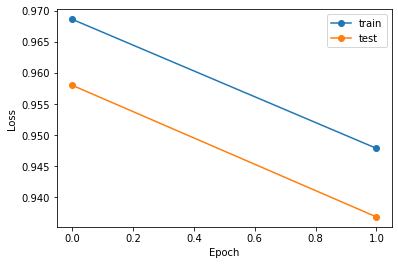

In [11]:
from collections.abc import Sequence
from importlib import reload  # Python 3.4+
import torch
from torch import nn
sys.path.append("/content/AI-Challenge-HIT/python_code/notebooks/AnomalyDetection/")
import networks
LSTMs = reload(networks)
from networks import LSTM_multiple_stations
from tqdm import tqdm

# specify the device ("cuda" for GPU, "cpu" for CPU)
device = torch.device("cuda")

# get dome parameters from the dataset
sequence_length = dataset['train'][0]['features'].size(0)
pred_length = dataset['train'][0]['target'].size(0)
# Instantiate the model with hyperparameters (NOTICE THE MULTIPLE FEATURES IN INPUT SIZE: ONE FOR EACH SENSOR OF THE GROUP)
model = LSTM_multiple_stations(input_size=3, output_size=3, hidden_dim=64, num_layers=5, device = device)
train_loss = []
test_loss = []

# We'll also set the model to the device that we defined earlier
model = model.to(device)

# Define hyperparameters
lr = 1e-5

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

n_epochs = 2
for epoch in range(1, n_epochs + 1):
    model.train()
    loss_train_batch = []
    for data in tqdm(dataloader['train'], leave=True, total=len(dataloader['train'])):
      # preparing the input
      batch_input_features = torch.stack([v["features"] for v in data]).to(device)
      target_features = torch.stack([v["target"] for v in data]).to(device)
      # feed the model and make the prediction
      output = model(batch_input_features,pred_length)
      output = output.to(device)[:,-pred_length:]
      # compute the loss
      loss_train = criterion(output, target_features)
      # backpropagation and gradients
      loss_train.backward() 
      # Update of the weights accordingly
      optimizer.step() 
      # Append the loss to batch list
      loss_train_batch.append(loss_train.item())
    
    # average on bath train loss
    mean_train_loss = np.mean(loss_train_batch)

    # test-time
    model.eval()
    test_input_features = dataset['test'].features.to(device)
    test_target_features = dataset['test'].target.to(device)
    
    # split when it is too fat (out of memory)
    test_input_features_splitted = np.array_split(test_input_features, SPLIT_NUMBER)
    output_test_list = []
    for input_feature_split_subset in test_input_features_splitted:
      output_test_list.append(model(input_feature_split_subset,pred_length)[:,-pred_length:])
    output_test_flat = [item for item in output_test_list]
    output_test = torch.cat(output_test_flat)
    # compute loss on test set for validation on unseen data
    loss_test = criterion(output_test, test_target_features)
    
    train_loss.append(mean_train_loss)
    test_loss.append(loss_test.item())
    print("Epoch = " + str(epoch))
    print("\tTraining Loss: {:.4f}".format(mean_train_loss))
    print("\tTest Loss: {:.4f}".format(loss_test.item()))

    # stop criterion on the train loss value
    if mean_train_loss < 0.010:
        break

# plot the training performance (todo: use W&B)
import matplotlib.pyplot as plt
plt.plot(train_loss,'o-',label="train")
plt.plot(test_loss,'o-',label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# save model
torch.save(model.state_dict(),
           os.path.join(wk, "TrainedModels/", "joint_"+sensor_type+"_model.pt")
)